In [26]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import librosa
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import random

In [27]:
# CRNN model architecture
# The model uses 3 CNN layers and 2 LSTM layers

class MusicGenreCRNN(nn.Module):
    def __init__(self, num_genres, input_channels):
        super(MusicGenreCRNN, self).__init__()
        
        # CNN Layers -used for feature extraction from spectrogram
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
        )
        
        self.rnn_input_size = 256 * 16  
        
        # RNN layers - used for temporal analysis of features
        self.rnn = nn.LSTM(
            input_size=self.rnn_input_size,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        
        self.attention = nn.Sequential(
            nn.Linear(256, 64), 
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_genres)
        )
    
    def forward(self, x):
        batch_size = x.size(0)
        x = self.cnn_layers(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(batch_size, -1, self.rnn_input_size)
        
        rnn_out, _ = self.rnn(x)
        
        attention_weights = self.attention(rnn_out)
        x = torch.sum(attention_weights * rnn_out, dim=1)
        
        x = self.classifier(x)
        return x, attention_weights

In [28]:
# This function gets the files for training and also testing
# In testing and visualizations, a lot of code is reused from the previous notebook
def get_files_and_labels(base_path):
    files = []
    labels = []
    
    genres = sorted(os.listdir(base_path))
    
    # Create genre to label mapping (e.g., 'blues': 0, 'classical': 1, etc.)
    # This is useful for converting genre names to integers for training
    genre_to_label = {genre: idx for idx, genre in enumerate(genres)}
    
    for genre in genres:
        genre_path = os.path.join(base_path, genre)
        if os.path.isdir(genre_path):
            for file in os.listdir(genre_path):
                if file.endswith(('.wav')):
                    files.append(os.path.join(genre_path, file))
                    labels.append(genre_to_label[genre])
    
    return files, labels, genre_to_label

# Test files   
test_path = "./data/test_files"   
test_files, test_labels, genre_mapping = get_files_and_labels(test_path)

def prepare_dataset():
    test_files, test_labels, _ = get_files_and_labels(test_path)
    
    return (test_files, test_labels), genre_mapping

(test_files, test_labels), genre_mapping = prepare_dataset()

In [29]:
# Uses Librosa to load the music files and convert them to mel spectrograms
# We also add some random augmentations to the data to make the model more robust

class MusicDataset(Dataset):
    def __init__(self, audio_files, labels):
        self.audio_files = audio_files
        self.labels = labels
        
    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        try:
            audio, sr = librosa.load(self.audio_files[idx], duration=15, sr=22050)

            # Random augmentations
            if np.random.random() > 0.5:
                rate = np.random.uniform(0.8, 1.2)
                audio = librosa.effects.time_stretch(audio, rate=rate)
            
            if np.random.random() > 0.5:
                steps = np.random.randint(-2, 3)
                audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=steps)
                
            # MEL spectrogram
            mel_spec = librosa.feature.melspectrogram(
                y=audio,
                sr=sr,
                n_mels=128,
                n_fft=2048,
                hop_length=512
            )
            
            # Log scale
            mel_spec = librosa.power_to_db(mel_spec)
            
            target_length = 1292
            if mel_spec.shape[1] > target_length:
                mel_spec = mel_spec[:, :target_length]
            elif mel_spec.shape[1] < target_length:
                pad_width = target_length - mel_spec.shape[1]
                mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
            


            mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-8)
            
            # Converts to PyTorch tensor
            mel_spec = torch.FloatTensor(mel_spec).unsqueeze(0)
            label = torch.LongTensor([self.labels[idx]])
            
            return mel_spec, label
            
        except Exception as e:
            print(f"Error processing index {idx}, file {self.audio_files[idx]}: {str(e)}")
            raise

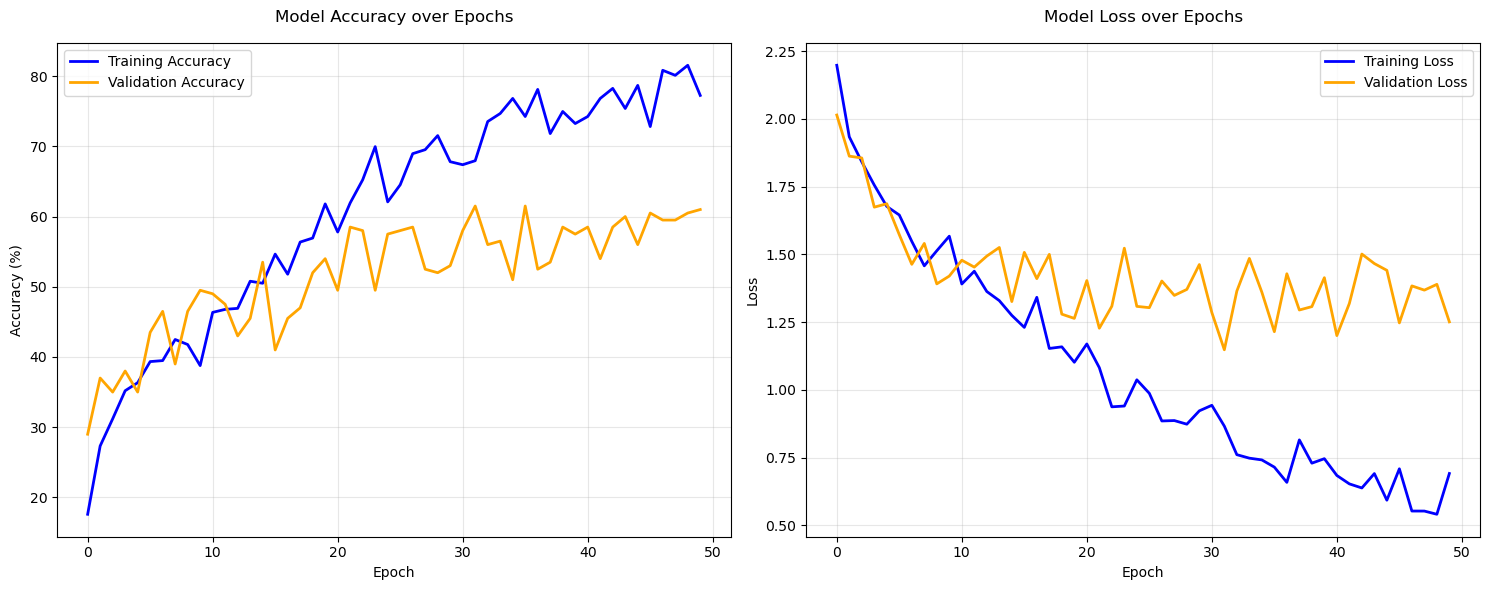


Training Statistics:
Best Training Accuracy: 81.55%
Best Validation Accuracy: 61.50%
Final Training Loss: 0.6915
Final Validation Loss: 1.2511

Improvement Analysis:
Initial Validation Accuracy: 29.00%
Final Validation Accuracy: 61.00%
Total Improvement: 32.00%
Average Improvement per Epoch: 0.64%

Best Epochs:
Best Training Accuracy (81.55%) at epoch 48
Best Validation Accuracy (61.50%) at epoch 31


In [30]:
# Training history plots - from the JSON file
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
with open('50ep15s_trainingHistory.json', 'r') as f:
    history = json.load(f)


plt.figure(figsize=(15, 6))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history['epoch'], history['train_acc'], 
         label='Training Accuracy', 
         color='blue', 
         linewidth=2)
plt.plot(history['epoch'], history['val_acc'], 
         label='Validation Accuracy', 
         color='orange', 
         linewidth=2)
plt.title('Model Accuracy over Epochs', size=12, pad=15)
plt.xlabel('Epoch', size=10)
plt.ylabel('Accuracy (%)', size=10)
plt.grid(True, alpha=0.3)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history['epoch'], history['train_loss'], 
         label='Training Loss', 
         color='blue', 
         linewidth=2)
plt.plot(history['epoch'], history['val_loss'], 
         label='Validation Loss', 
         color='orange', 
         linewidth=2)
plt.title('Model Loss over Epochs', size=12, pad=15)
plt.xlabel('Epoch', size=10)
plt.ylabel('Loss', size=10)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Prints statistics for better overview
print("\nTraining Statistics:")
print(f"Best Training Accuracy: {max(history['train_acc']):.2f}%")
print(f"Best Validation Accuracy: {max(history['val_acc']):.2f}%")
print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")


# Relative improvement analysis and best epochs
def calculate_improvement_rate(history):
    initial_acc = history['val_acc'][0]
    final_acc = history['val_acc'][-1]
    total_epochs = len(history['epoch'])
    
    improvement = final_acc - initial_acc
    rate = improvement / total_epochs
    
    print(f"\nImprovement Analysis:")
    print(f"Initial Validation Accuracy: {initial_acc:.2f}%")
    print(f"Final Validation Accuracy: {final_acc:.2f}%")
    print(f"Total Improvement: {improvement:.2f}%")
    print(f"Average Improvement per Epoch: {rate:.2f}%")

calculate_improvement_rate(history)

#  Best epochs
best_train_epoch = history['epoch'][np.argmax(history['train_acc'])]
best_val_epoch = history['epoch'][np.argmax(history['val_acc'])]

print(f"\nBest Epochs:")
print(f"Best Training Accuracy ({max(history['train_acc']):.2f}%) at epoch {best_train_epoch}")
print(f"Best Validation Accuracy ({max(history['val_acc']):.2f}%) at epoch {best_val_epoch}")

C:\Users\JuliusBudrikas\AppData\Local\Temp\ipykernel_6008\4109495625.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('50ep15s_model.pth')



Test Set Results:
Accuracy: 61.00%


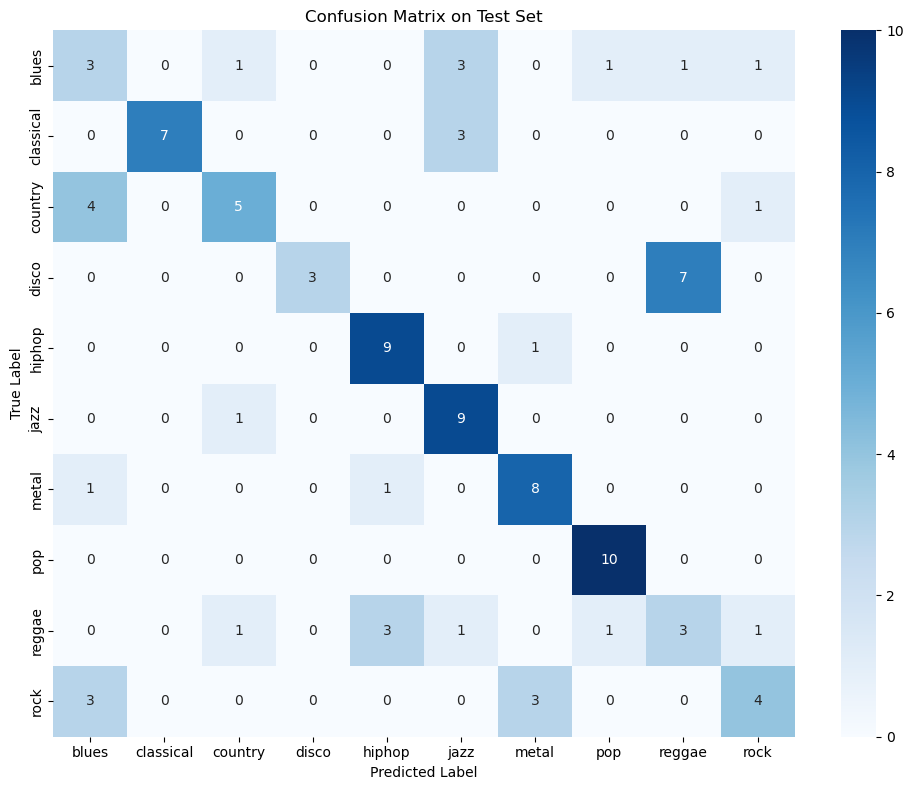


Classification Report:
              precision    recall  f1-score   support

       blues       0.27      0.30      0.29        10
   classical       1.00      0.70      0.82        10
     country       0.62      0.50      0.56        10
       disco       1.00      0.30      0.46        10
      hiphop       0.69      0.90      0.78        10
        jazz       0.56      0.90      0.69        10
       metal       0.67      0.80      0.73        10
         pop       0.83      1.00      0.91        10
      reggae       0.27      0.30      0.29        10
        rock       0.57      0.40      0.47        10

    accuracy                           0.61       100
   macro avg       0.65      0.61      0.60       100
weighted avg       0.65      0.61      0.60       100



In [31]:
# Prints the accuracy and confusion matrix
def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).squeeze()
            outputs, _ = model(inputs)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100. * correct / total
    print(f'\nTest Set Results:')
    print(f'Accuracy: {accuracy:.2f}%')
    
    # Confusion matrix across different genres
    class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix on Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print('\nClassification Report:')
    print(classification_report(all_labels, all_predictions, target_names=class_names))
    
    return accuracy, cm


# Create test dataset and loader
test_dataset = MusicDataset(test_files, test_labels)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0
)

checkpoint = torch.load('50ep15s_model.pth')
# Dynamically get the number of genres
num_genres = checkpoint['model_state_dict']['classifier.3.weight'].size(0)
model = MusicGenreCRNN(num_genres=num_genres, input_channels=1)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to('cpu') # CPU works fine here for evaluation, as the model is not that big or complex

test_accuracy, confusion_mat = evaluate_model(model, test_loader)

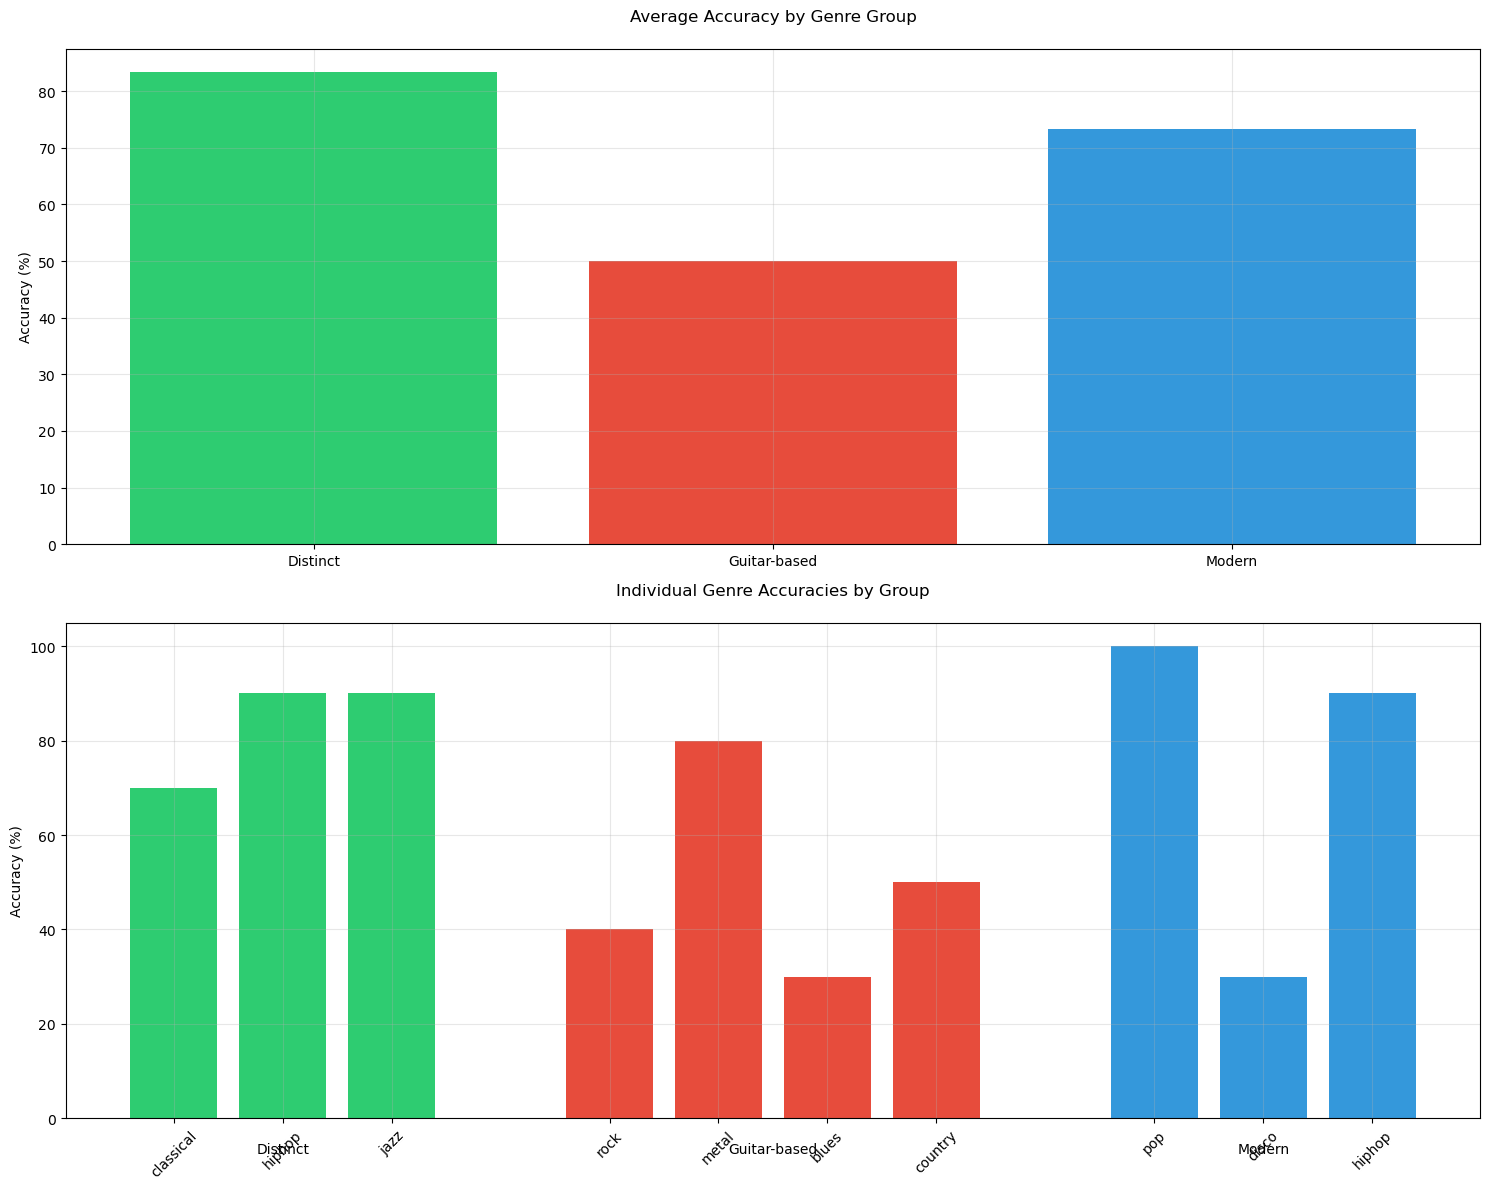


Detailed Accuracy Statistics:
----------------------------------------

Distinct Group:
Average Accuracy: 83.33%
Classical: 70.00%
Hiphop: 90.00%
Jazz: 90.00%

Guitar-based Group:
Average Accuracy: 50.00%
Rock: 40.00%
Metal: 80.00%
Blues: 30.00%
Country: 50.00%

Modern Group:
Average Accuracy: 73.33%
Pop: 100.00%
Disco: 30.00%
Hiphop: 90.00%


In [32]:
# We defined 3 genre groups based on either their similarity or the instruments used / features
# Fun but handy analysis that provides some context of the models performance

genre_groups = {
    'Distinct': ['classical', 'hiphop', 'jazz'],
    'Guitar-based': ['rock', 'metal', 'blues', 'country'],
    'Modern': ['pop', 'disco', 'hiphop']
}

def analyze_genre_groups(confusion_matrix, class_names, genre_groups):
    accuracies = {}
    for group_name, genres in genre_groups.items():
        indices = [class_names.index(genre) for genre in genres]
        group_acc = confusion_matrix[indices][:, indices].diagonal().mean()
        accuracies[group_name] = group_acc
    return accuracies

def plot_genre_group_accuracies(confusion_matrix, class_names):    
    group_accuracies = {}
    
    # Calculates accuracies per genre group
    for group_name, genres in genre_groups.items():
        valid_genres = []
        valid_accuracies = []
        
        for genre in genres:
            if genre in class_names:
                idx = class_names.index(genre)
                acc = confusion_matrix[idx][idx]/sum(confusion_matrix[idx]) * 100
                valid_genres.append(genre)
                valid_accuracies.append(acc)
        
        if valid_genres:
            group_accuracies[group_name] = {
                'mean': np.mean(valid_accuracies),
                'individual': dict(zip(valid_genres, valid_accuracies))
            }
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Group averages
    group_means = [data['mean'] for data in group_accuracies.values()]
    ax1.bar(group_accuracies.keys(), group_means, color=['#2ecc71', '#e74c3c', '#3498db'])
    ax1.set_title('Average Accuracy by Genre Group', pad=20)
    ax1.set_ylabel('Accuracy (%)')
    ax1.grid(True, alpha=0.3)
    
    # Individual genres
    all_genres = []
    all_accuracies = []
    all_colors = []
    
    # Each group seperately
    current_position = 0
    x_positions = []
    
    for group_name, data in group_accuracies.items():
        genres = list(data['individual'].keys())
        accuracies = list(data['individual'].values())
        

        if current_position > 0:
            current_position += 1
        positions = range(current_position, current_position + len(genres))
        x_positions.extend(positions)
        current_position += len(genres)
        
        all_genres.extend(genres)
        all_accuracies.extend(accuracies)
        
        # Color schemes
        if group_name == 'Distinct':
            all_colors.extend(['#2ecc71'] * len(genres))
        elif group_name == 'Guitar-based':
            all_colors.extend(['#e74c3c'] * len(genres))
        else:  # Modern
            all_colors.extend(['#3498db'] * len(genres))
    
    ax2.bar(x_positions, all_accuracies, color=all_colors)
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels(all_genres, rotation=45)
    
    group_positions = []
    current_pos = 0
    for group_name, data in group_accuracies.items():
        group_size = len(data['individual'])
        group_pos = current_pos + (group_size - 1) / 2
        group_positions.append(group_pos)
        current_pos += group_size + 1
    
    for pos, name in zip(group_positions, group_accuracies.keys()):
        ax2.text(pos, -5, name, ha='center', va='top')
    
    ax2.set_title('Individual Genre Accuracies by Group', pad=20)
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Accuracy per genre
accuracies_per_genre = confusion_mat.diagonal() / confusion_mat.sum(axis=1) * 100
plot_genre_group_accuracies(confusion_mat, class_names)

# Metrics and statistics for each genre and genre group
print("\nDetailed Accuracy Statistics:")
print("-" * 40)
for group_name, genres in genre_groups.items():
    print(f"\n{group_name} Group:")
    group_indices = [class_names.index(genre) for genre in genres if genre in class_names]
    group_accs = [accuracies_per_genre[i] for i in group_indices]
    print(f"Average Accuracy: {np.mean(group_accs):.2f}%")
    for genre, acc in zip(genres, group_accs):
        print(f"{genre.capitalize()}: {acc:.2f}%")

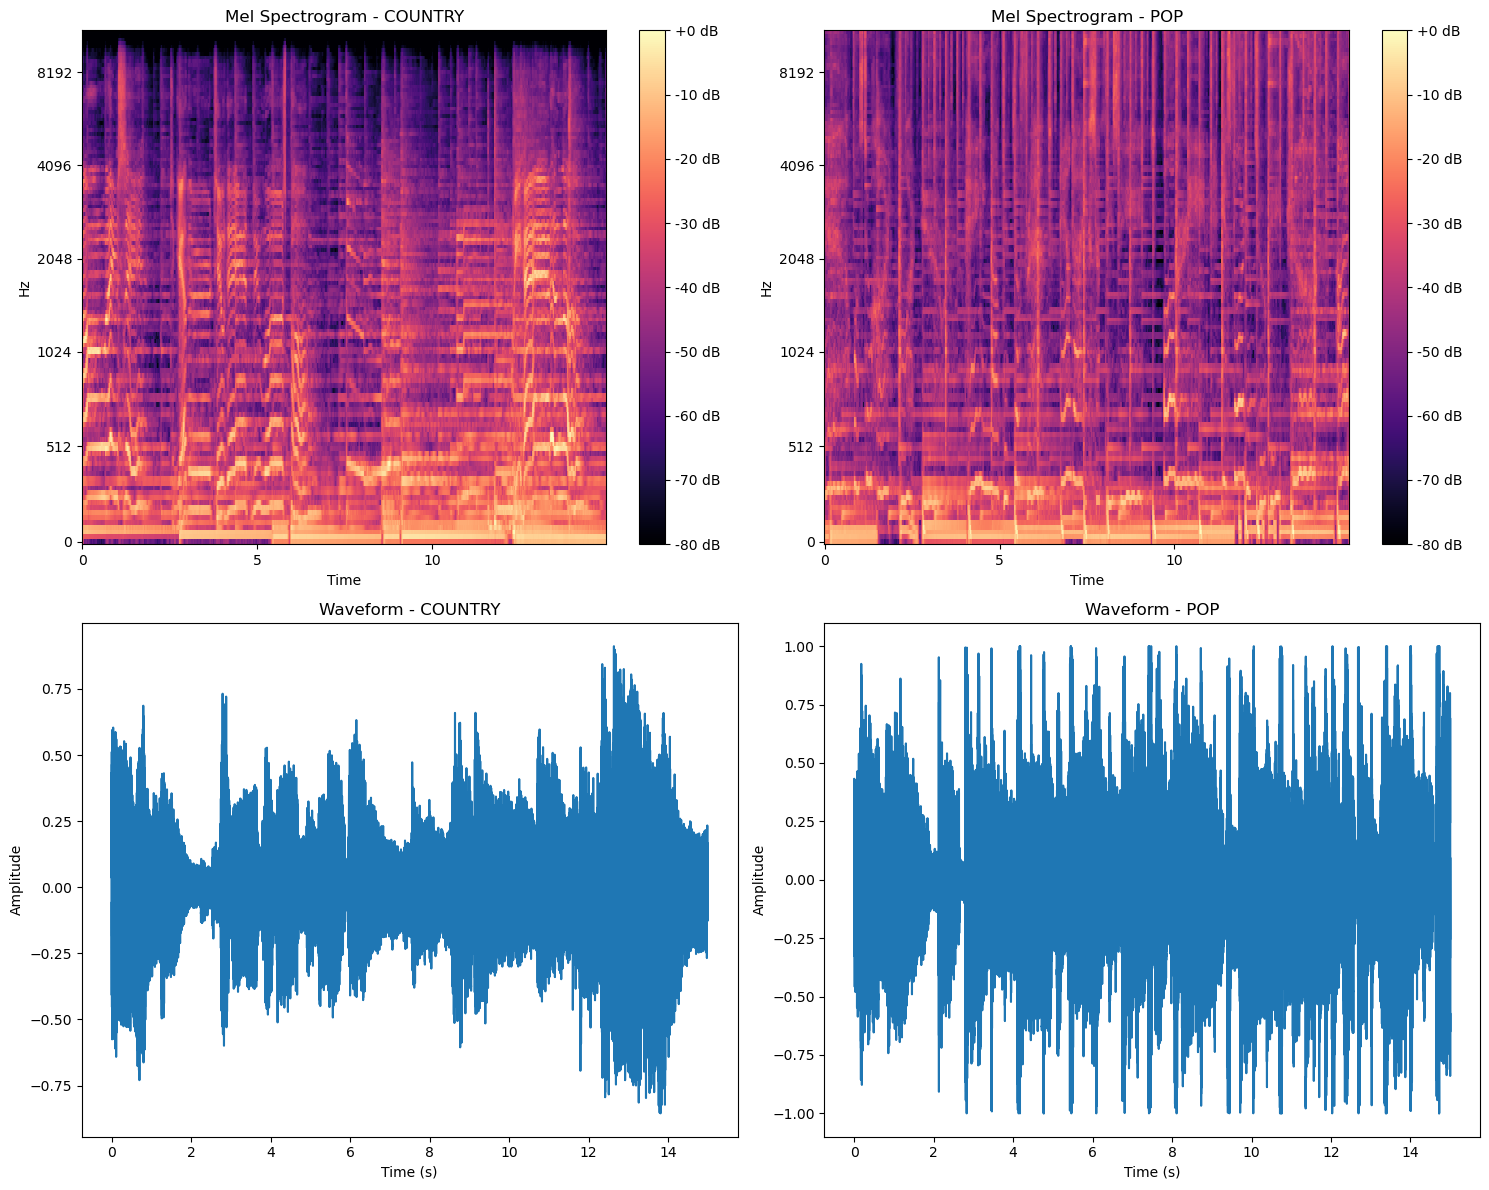

In [33]:
# Example MEL spectogram and waveform plots of country and pop music genres
# Shows a clear difference in the features and how the model can distinguish between them

def plot_spectogram_and_waveform(files_dict, genres=['country', 'pop']):
   fig, axes = plt.subplots(2, 2, figsize=(15, 12))
   
   for idx, genre in enumerate(genres):
       genre_files = [f for f in test_files if genre in f]
       sample_file = random.choice(genre_files)
       audio, sr = librosa.load(sample_file, duration=15)
       
       # MEL Spectrogram
       mel_spect = librosa.feature.melspectrogram(
           y=audio,
           sr=sr,
           n_mels=128,
           n_fft=2048,
           hop_length=512
       )
       mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
       img = librosa.display.specshow(
           mel_spect_db,
           x_axis='time',
           y_axis='mel',
           ax=axes[0, idx]
       )
       axes[0, idx].set_title(f'Mel Spectrogram - {genre.upper()}')
       fig.colorbar(img, ax=axes[0, idx], format='%+2.0f dB')
       
       # Waveform
       axes[1, idx].plot(np.linspace(0, 15, len(audio)), audio)
       axes[1, idx].set_title(f'Waveform - {genre.upper()}')
       axes[1, idx].set_xlabel('Time (s)')
       axes[1, idx].set_ylabel('Amplitude')
   
   plt.tight_layout()
   plt.show()

plot_spectogram_and_waveform(test_files)